In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [49]:
valid_size = .05
batch_size = 16
num_workers = 2
classes = ["Real", "Fake"]

train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.ToTensor(),
                               transforms.Normalize([.485, .456, .406], [.229, .224, .225])])

test_transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                               transforms.Normalize([.485, .456, .406], [.229, .224, .225])])

categories = os.listdir("./progan_train")
train_datasets = []
print("Loading Training Data...", flush=True)
for category in tqdm(categories):
    train_datasets.append(datasets.ImageFolder("./progan_train/" + category, transform=train_transform))
    
train_dataset = torch.utils.data.ConcatDataset(train_datasets)


#train_dataset = datasets.ImageFolder("./progan_train/horse/", transform=train_transform)

print("Loading Testing Data...", flush=True)
test_datasets = []
for category in tqdm(categories):
    test_datasets.append(datasets.ImageFolder("./CNN_synth_testset/progan/" + category, transform=test_transform))
    
test_dataset = torch.utils.data.ConcatDataset(test_datasets)

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                               num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

class_names = train_datasets[0].classes


Loading Training Data...


100%|██████████| 20/20 [00:02<00:00,  9.47it/s]

Loading Testing Data...



100%|██████████| 20/20 [00:00<00:00, 192.18it/s]


In [52]:
torch.save(train_loader, "./spec/train_loader.pt")
torch.save(valid_loader, "./spec/valid_loader.pt")
torch.save(test_loader, "./spec/test_loader.pt")

In [54]:
train_loader = torch.load("./spec/train_loader.pt")
valid_loader = torch.load("./spec/valid_loader.pt")
test_loader = torch.load("./spec/test_loader.pt")
len(train_loader), len(valid_loader), len(test_loader)

(42758, 2251, 500)

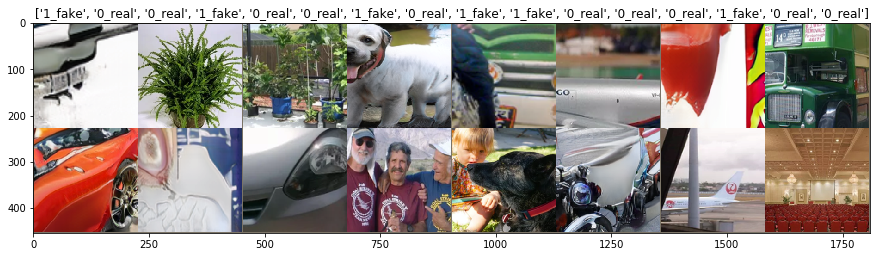

In [55]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


plt.figure(figsize=(15,15))
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [57]:
resnet = models.resnet18(pretrained=True)

model = nn.Sequential(resnet, nn.Linear(1000, 2))
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = .9)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 5
since = time.time()
print_every_n_batches = 3000
losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    #running_corrects = 0
    
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        #_, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        #running_corrects += torch.sum(preds == labels.data)
        
        if i % print_every_n_batches == print_every_n_batches - 1:
            #Calculate validation loss
            n = 0
            acc = torch.tensor(0).to(device)
            for data in valid_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                y_pred = torch.argmax(model(inputs), 1) 
                acc = torch.add(acc, torch.sum(y_pred == labels))
                n += len(labels)

            val_acc = acc / float(n)
            print('[%d, %5d] training loss: %.3f val acc: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every_n_batches, val_acc), end = " ")
            val_accs.append(val_acc)
            losses.append(running_loss / print_every_n_batches)
            running_loss = 0.0
            
    
            time_elapsed = time.time() - since
            print(f'Time elapsed: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    torch.save(model, "./spec/model" + str(epoch) + ".pt")
        
time_elapsed = time.time() - since
print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Epoch 1/5
----------
[1,  3000] training loss: 0.525 val acc: 0.904 Time elapsed: 16m 1s
[1,  6000] training loss: 0.151 val acc: 0.963 Time elapsed: 28m 41s
[1,  9000] training loss: 0.095 val acc: 0.971 Time elapsed: 39m 32s
[1, 12000] training loss: 0.079 val acc: 0.967 Time elapsed: 50m 45s
[1, 15000] training loss: 0.059 val acc: 0.983 Time elapsed: 61m 25s
[1, 18000] training loss: 0.050 val acc: 0.987 Time elapsed: 71m 37s
[1, 21000] training loss: 0.033 val acc: 0.992 Time elapsed: 81m 4s
[1, 24000] training loss: 0.032 val acc: 0.987 Time elapsed: 90m 57s
[1, 27000] training loss: 0.029 val acc: 0.984 Time elapsed: 101m 40s
[1, 30000] training loss: 0.032 val acc: 0.992 Time elapsed: 112m 38s
[1, 33000] training loss: 0.023 val acc: 0.991 Time elapsed: 123m 10s
[1, 36000] training loss: 0.025 val acc: 0.993 Time elapsed: 134m 43s
[1, 39000] training loss: 0.019 val acc: 0.991 Time elapsed: 145m 46s
[1, 42000] training loss: 0.017 val acc: 0.994 Time elapsed: 156m 50s


/share/pkg.7/pytorch/1.3/install/3.6/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/share/pkg.7/pytorch/1.3/install/3.6/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/share/pkg.7/pytorch/1.3/install/3.6/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/share/pkg.7/pytorch/1.3/install/3.6/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked f

Epoch 2/5
----------
[2,  3000] training loss: 0.020 val acc: 0.992 Time elapsed: 164m 38s
[2,  6000] training loss: 0.017 val acc: 0.996 Time elapsed: 170m 47s
[2,  9000] training loss: 0.015 val acc: 0.996 Time elapsed: 177m 24s
[2, 12000] training loss: 0.013 val acc: 0.995 Time elapsed: 184m 3s
[2, 15000] training loss: 0.011 val acc: 0.996 Time elapsed: 190m 34s
[2, 18000] training loss: 0.012 val acc: 0.996 Time elapsed: 196m 37s
[2, 21000] training loss: 0.012 val acc: 0.997 Time elapsed: 202m 53s
[2, 24000] training loss: 0.013 val acc: 0.998 Time elapsed: 211m 11s
[2, 27000] training loss: 0.012 val acc: 0.994 Time elapsed: 217m 60s
[2, 30000] training loss: 0.009 val acc: 0.998 Time elapsed: 225m 6s
[2, 33000] training loss: 0.009 val acc: 0.995 Time elapsed: 231m 2s
[2, 36000] training loss: 0.009 val acc: 0.996 Time elapsed: 237m 14s
[2, 39000] training loss: 0.008 val acc: 0.997 Time elapsed: 243m 4s
[2, 42000] training loss: 0.010 val acc: 0.997 Time elapsed: 249m 21s
Epo

In [64]:
torch.save(model, "./spec/paranoid_save.pt")

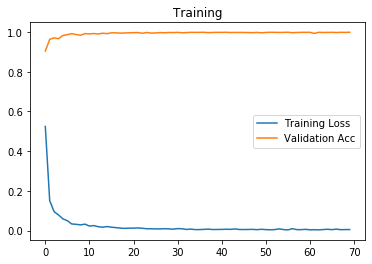

In [60]:
plt.title("Training")
plt.plot(losses, label="Training Loss")
plt.plot(val_accs, label="Validation Acc")
plt.legend()

In [63]:
#Don't know why output for epochs 4 and 5 got cut off but this is the test run, 99.74% acc

In [62]:
n = 0
acc = torch.tensor(0).to(device)
for data in test_loader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    y_pred = torch.argmax(model.forward(inputs), 1) 
    acc = torch.add(acc, torch.sum(y_pred == labels))
    n += len(labels)
    
acc / float(n)

tensor(0.9974, device='cuda:0')

In [77]:
gans = os.listdir("./CNN_synth_testset")
test_accs = []
gans.remove("progan")
for gan in tqdm(gans):
    subdirs = os.listdir("./CNN_synth_testset/" + gan)
    if len(subdirs) == 2:
        gan_dataset = datasets.ImageFolder("./CNN_synth_testset/" + gan, transform=test_transform)
    else:
        gan_datasets = [datasets.ImageFolder("./CNN_synth_testset/" + gan + "/" + cat, transform=test_transform) for cat in subdirs]
        gan_dataset = torch.utils.data.ConcatDataset(gan_datasets)
        
    gan_loader = torch.utils.data.DataLoader(gan_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
        
    n = 0
    acc = torch.tensor(0).to(device)
    for data in gan_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        y_pred = torch.argmax(model.forward(inputs), 1) 
        acc = torch.add(acc, torch.sum(y_pred == labels))
        n += len(labels)
    
    test_accs.append(acc / float(n))

100%|██████████| 12/12 [08:30<00:00, 42.54s/it]


<BarContainer object of 12 artists>

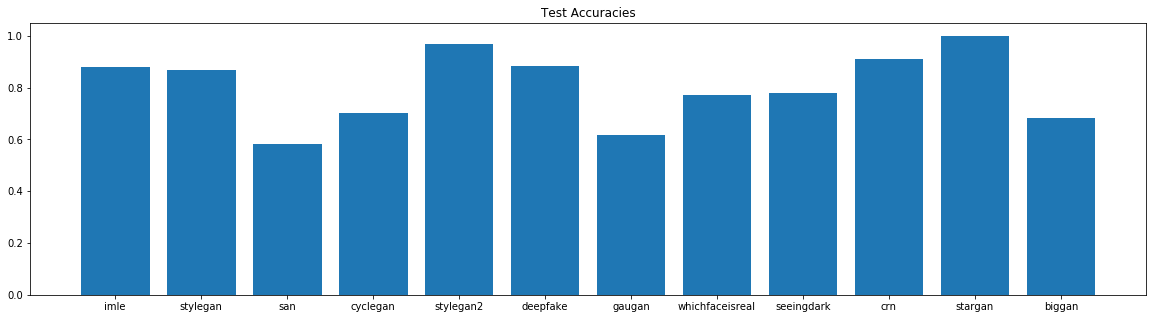

In [83]:
plt.figure(figsize=(20,5))
plt.title("Test Accuracies")
plt.bar(gans, test_accs)

In [84]:
import pickle
with open("./spec/test_accs.txt", "wb") as file:
    pickle.dump(test_accs, file)

In [1]:
import pickle
with open("./spec/test_accs.txt", "rb") as file:
    test_accs = pickle.load(file)
test_accs

[tensor(0.8814, device='cuda:0'),
 tensor(0.8691, device='cuda:0'),
 tensor(0.5822, device='cuda:0'),
 tensor(0.7029, device='cuda:0'),
 tensor(0.9689, device='cuda:0'),
 tensor(0.8823, device='cuda:0'),
 tensor(0.6154, device='cuda:0'),
 tensor(0.7715, device='cuda:0'),
 tensor(0.7778, device='cuda:0'),
 tensor(0.9120, device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(0.6843, device='cuda:0')]